# Loading Data

In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from matplotlib.ticker import MaxNLocator, FuncFormatter, PercentFormatter
import pycountry_convert as pc


olymp = pd.read_csv("data/athlete_events.csv")
noc_regions = pd.read_csv("data/noc_regions.csv")
olymp.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


# Defining Questions

1. How has athlete participation changed over time across countries and continents? 
2. Which countries dominate Olympic performance, and how has dominance shifted over time?
3. Can we predict how many medals a country will win based on its delegation size and historical characteristics? ( fit a poisson regression model (?) )

# Data Collection

Our work uses the dataset titled 120 years of Olympic history: athletes and results on kaggle (https://www.kaggle.com/datasets/heesoo37/120-years-of-olympic-history-athletes-and-results). This is a public dataset that contaians information information since 1896 to 2016. The dataset has 271,116 rows where each row is corresponds to an individual athlete.

# Data Cleaning and Preparation

Talk about the steps we took mapping noc to actual country name and continent.
We also take only the summer olympics.
We will have to standardize country and region information, handle missing/problematic values, and aggregate data to country year summaries that we need for medal trends and participation.

Many demographic values contain missing entries. However, because our main research questions do not heavily rely on these features, and imputing historical physical data might introduce bias, we choose to exclude them from our analysis. The most important variables like Year, NOC, Medal, and Sex are all available.

To ensure accuracy and consistency in our analysis, we performed several data cleaning and preparation steps. Our cleaning process focused on:

1. Filtering to Summer Olympics only

2. Mapping NOC codes to consistent country names

3. Assigning each country to a continent

4. Handling missing or irrelevant fields

5. Engineering medal-related features

6. Aggregating the data to country-year level for later analysis

In [175]:
import pycountry_convert as pc # pip install pycountry pycountry_convert

def country_to_continent(country):
    """
    Convert country name → continent name using pycountry_convert.
    Returns None if lookup fails.
    """
    try:
        iso = pc.country_name_to_country_alpha2(country)
        cont_code = pc.country_alpha2_to_continent_code(iso)
        return {
            "AF": "Africa",
            "AS": "Asia",
            "EU": "Europe",
            "NA": "North America",
            "OC": "Oceania",
            "SA": "South America"
        }[cont_code]
    except:
        return None

manual_continent_overrides = {
    "Serbia and Montenegro": "Europe",
    "Yugoslavia": "Europe",
    "Czechoslovakia": "Europe",
    "Syria": "Asia",
    "Hong Kong": "Asia",
    "Curacao": "North America",
    "Virgin Islands, US": "North America",
    "Virgin Islands, British": "North America",
    "West Indies Federation": "North America",
    "Refugee Olympic Team": None,
    "Individual Olympic Athletes": None,
    "NA": None,
}

def resolve_continent(row):
    country = row["country_name"]
    if country in manual_continent_overrides:
        return manual_continent_overrides[country]
    return country_to_continent(country)


host_country_map = {
    1896: "Greece",
    1900: "France",
    1904: "USA",
    1908: "UK",
    1912: "Sweden",
    1920: "Belgium",
    1924: "France",
    1928: "Netherlands",
    1932: "USA",
    1936: "Germany",
    1948: "UK",
    1952: "Finland",
    1956: "Australia",
    1960: "Italy",
    1964: "Japan",
    1968: "Mexico",
    1972: "Germany",
    1976: "Canada",
    1980: "Russia",           # USSR -> Russia
    1984: "USA",
    1988: "South Korea",
    1992: "Spain",
    1996: "USA",
    2000: "Australia",
    2004: "Greece",
    2008: "China",
    2012: "UK",
    2016: "Brazil", # we only have data to 2016
}


In [176]:
olympics_summer = olymp[olymp['Season'] == "Summer"]

# Merge NOC mappings
olympics_summer = olympics_summer.merge(noc_regions, on="NOC", how="left")
olympics_summer.rename(columns={"region": "country_name"}, inplace=True)

olympics_summer["continent"] = olympics_summer.apply(resolve_continent, axis=1)

# Medal quality fields
olympics_summer["has_medal"] = olympics_summer["Medal"].notna().astype(int)
olympics_summer["is_gold"]   = (olympics_summer["Medal"] == "Gold").astype(int)
olympics_summer["is_silver"] = (olympics_summer["Medal"] == "Silver").astype(int)
olympics_summer["is_bronze"] = (olympics_summer["Medal"] == "Bronze").astype(int)

olympics_summer["medal_quality_score"] = (
    3 * olympics_summer["is_gold"]
    + 2 * olympics_summer["is_silver"]
    + 1 * olympics_summer["is_bronze"]
)

# Country-year summary
country_year = (
    olympics_summer.groupby(["Year", "NOC", "country_name", "continent"])
    .agg(
        n_athletes=("ID", lambda x: x.nunique()),
        n_medals=("has_medal", "sum"),
        n_gold=("is_gold", "sum"),
        n_silver=("is_silver", "sum"),
        n_bronze=("is_bronze", "sum"),
        total_medal_quality=("medal_quality_score", "sum")
    )
    .reset_index()
)

# Medal efficiency
country_year["medals_per_athlete"] = (
    country_year["n_medals"] / country_year["n_athletes"]
).replace([float("inf"), -float("inf")], pd.NA)


# share of medals by continent over time
medals_continent_year = (
    country_year.groupby(["Year", "continent"])["n_medals"]
    .sum()
    .reset_index()
)

total_medals_year = (
    medals_continent_year.groupby("Year")["n_medals"]
    .sum()
    .reset_index(name="total_medals")
)

medals_continent_year = medals_continent_year.merge(total_medals_year, on="Year")
medals_continent_year["medal_share"] = (
    medals_continent_year["n_medals"] / medals_continent_year["total_medals"]
)

# Percent of athletes per continent each year
percent_athletes_continent_year = (
    country_year.dropna(subset=['continent'])
      .groupby(['continent','Year'], as_index=False)['n_athletes']
      .sum()
)
percent_athletes_continent_year['pct'] = percent_athletes_continent_year.groupby('Year')['n_athletes'].transform(
    lambda x: x / x.sum()
)

# adding host_country to data frame
country_year["host_country"] = country_year["Year"].map(host_country_map)
country_year["is_host"] = (country_year["country_name"] == country_year["host_country"]).astype(int)

# Data Analysis

## EDA

In [177]:
olympics_summer.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,Event,Medal,country_name,notes,continent,has_medal,is_gold,is_silver,is_bronze,medal_quality_score
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,...,Basketball Men's Basketball,NaN,China,NaN,Asia,0,0,0,0,0
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,...,Judo Men's Extra-Lightweight,NaN,China,NaN,Asia,0,0,0,0,0
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,...,Football Men's Football,NaN,Denmark,NaN,Europe,0,0,0,0,0
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,...,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN,Europe,1,1,0,0,3
4,8,"Cornelia ""Cor"" Aalten (-Strannood)",F,18.0,168.0,NaN,Netherlands,NED,1932 Summer,1932,...,Athletics Women's 100 metres,NaN,Netherlands,NaN,Europe,0,0,0,0,0


In [178]:
olympics_summer.info()

olympics_summer.describe()
olympics_summer.columns
country_year.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222552 entries, 0 to 222551
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   222552 non-null  int64  
 1   Name                 222552 non-null  object 
 2   Sex                  222552 non-null  object 
 3   Age                  213363 non-null  float64
 4   Height               170695 non-null  float64
 5   Weight               168698 non-null  float64
 6   Team                 222552 non-null  object 
 7   NOC                  222552 non-null  object 
 8   Games                222552 non-null  object 
 9   Year                 222552 non-null  int64  
 10  Season               222552 non-null  object 
 11  City                 222552 non-null  object 
 12  Sport                222552 non-null  object 
 13  Event                222552 non-null  object 
 14  Medal                34088 non-null   object 
 15  country_name     

Index(['Year', 'NOC', 'country_name', 'continent', 'n_athletes', 'n_medals',
       'n_gold', 'n_silver', 'n_bronze', 'total_medal_quality',
       'medals_per_athlete', 'host_country', 'is_host'],
      dtype='object')

#### Total Athletes Over Time by Continent

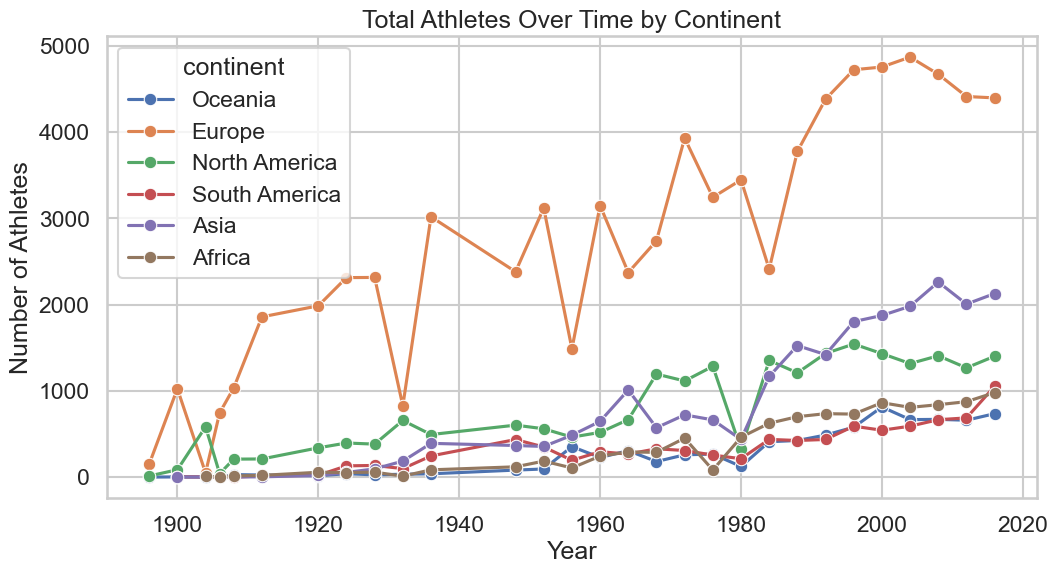

In [179]:
# Participation Trends

# number of athletes over time
plt.figure(figsize=(12,6))
sns.lineplot(
    data=country_year,
    x="Year",
    y="n_athletes",
    hue="continent",
    marker="o",
    estimator="sum",
    errorbar=None
)
plt.title("Total Athletes Over Time by Continent")
plt.ylabel("Number of Athletes")
plt.show()

#### Number of Participating Countries Over Time

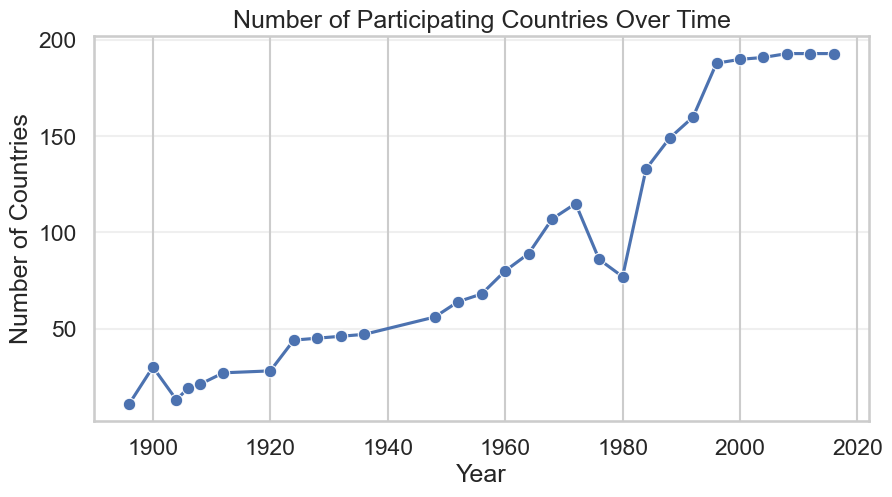

In [180]:
# Number of countries per year
countries_per_year = (
    country_year.groupby("Year")["country_name"]
    .nunique()
    .reset_index(name="n_countries")
)

plt.figure(figsize=(10,5))
sns.lineplot(data=countries_per_year, x="Year", y="n_countries", marker="o")
plt.title("Number of Participating Countries Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Countries")
plt.grid(True, axis='y', alpha=0.3)
plt.show()

#### Number of Participating Countries by Continent Over Time

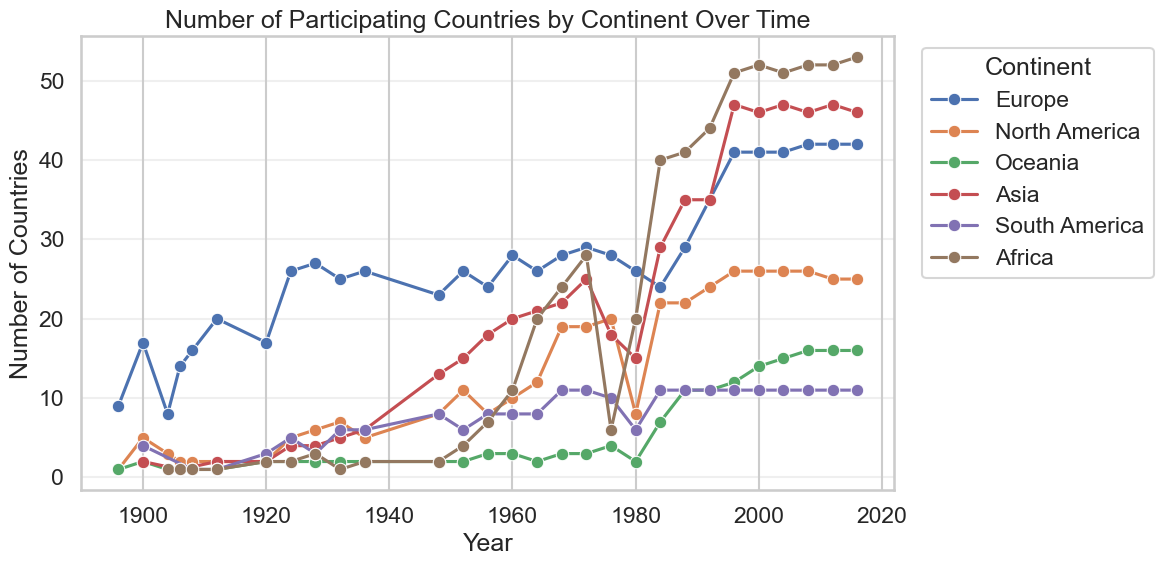

In [181]:
# Number of countries per year by continent
countries_per_year_continent = (
    country_year.groupby(["Year", "continent"])["country_name"]
    .nunique()
    .reset_index(name="n_countries")
)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=countries_per_year_continent,
    x="Year", y="n_countries", hue="continent",
    marker="o"
)
plt.title("Number of Participating Countries by Continent Over Time")
plt.xlabel("Year"); plt.ylabel("Number of Countries")
plt.grid(True, axis='y', alpha=0.3)
plt.legend(title="Continent", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

#### Share of Athletes by Continent

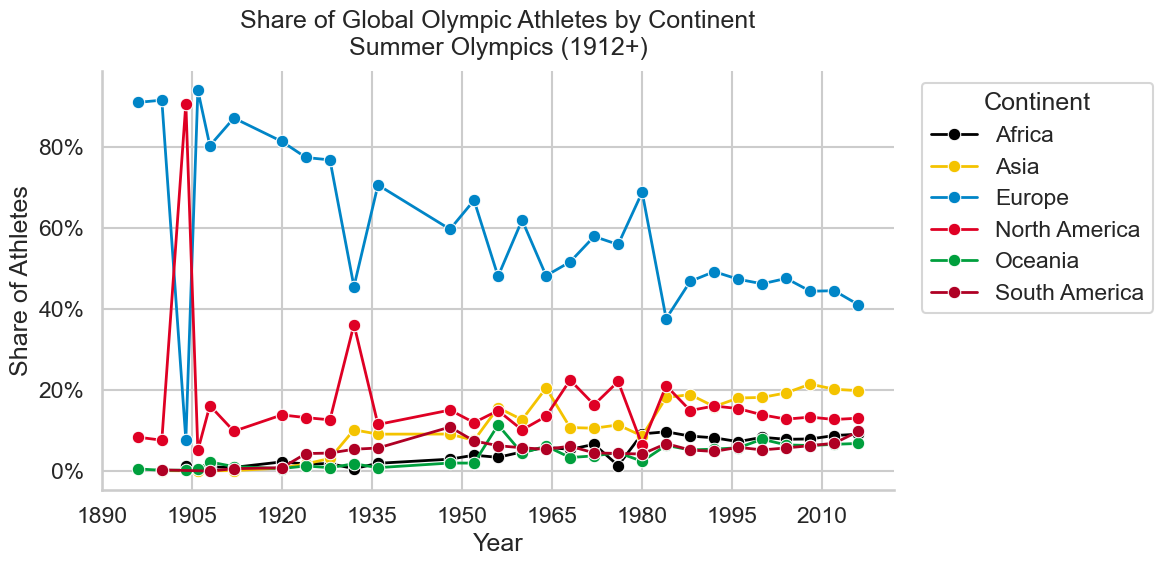

In [182]:
continent_colors = {
    "Europe":   "#0085C7",  # Blue
    "Asia":     "#F4C300",  # Yellow
    "Africa":   "#000000",  # Black
    "Oceania":  "#009F3D",  # Green
    "North America": "#DF0024",  # Red
    "South America": "#AF0024", 

}

# Share of athletes by contient
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=percent_athletes_continent_year, x='Year', y='pct', hue='continent', marker='o', linewidth=2, palette=continent_colors)
ax.set_title("Share of Global Olympic Athletes by Continent\nSummer Olympics (1912+)", pad=12)
ax.set_xlabel("Year"); ax.set_ylabel("Share of Athletes")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(title='Continent', bbox_to_anchor=(1.02,1), loc='upper left')
sns.despine(); plt.tight_layout(); plt.show()

#### Continental Medal Share Over Time

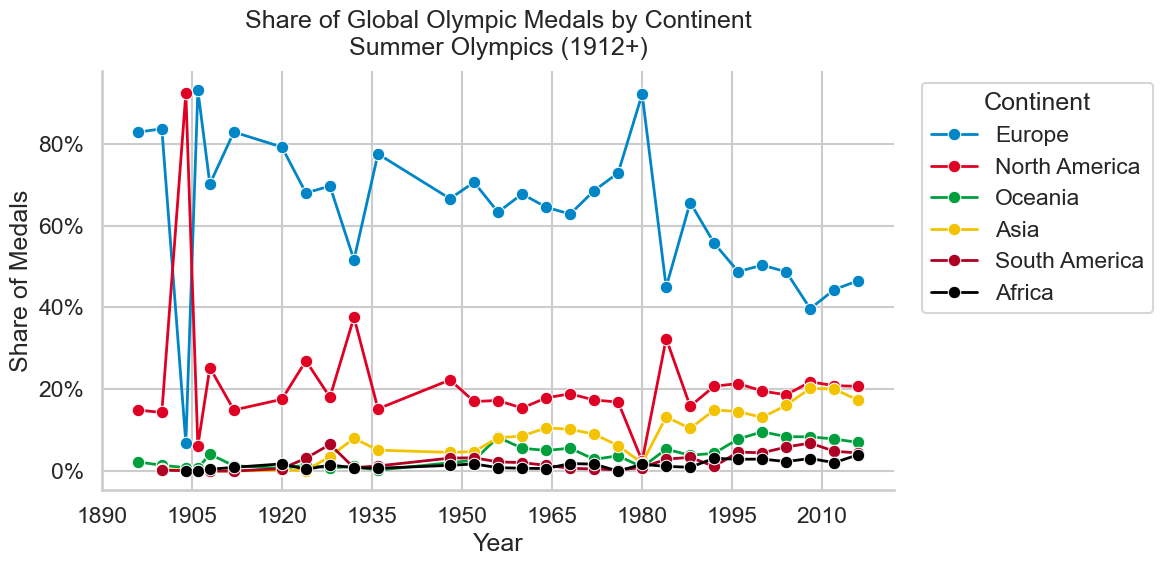

In [183]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(
    data=medals_continent_year,
    x="Year", y="medal_share", hue="continent",
    marker="o", linewidth=2, palette=continent_colors
)
ax.set_title("Share of Global Olympic Medals by Continent\nSummer Olympics (1912+)", pad=12)
ax.set_xlabel("Year")
ax.set_ylabel("Share of Medals")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(title="Continent", bbox_to_anchor=(1.02,1), loc="upper left")
sns.despine(); plt.tight_layout(); plt.show()


#### Medal Efficiency (Medals per Athlete)

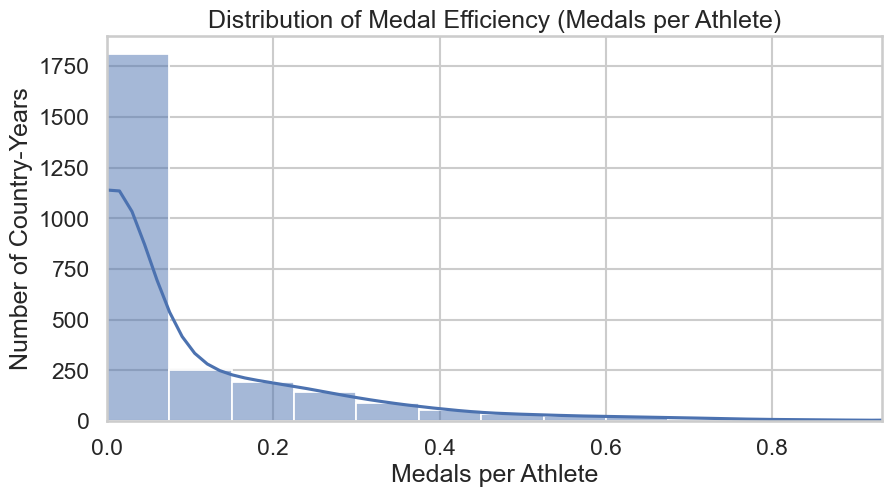

In [184]:
plt.figure(figsize=(10,5))
sns.histplot(
    data=country_year,
    x="medals_per_athlete",
    bins=40,
    kde=True
)
plt.title("Distribution of Medal Efficiency (Medals per Athlete)")
plt.xlabel("Medals per Athlete")
plt.ylabel("Number of Country-Years")
plt.xlim(0, country_year["medals_per_athlete"].quantile(0.99))  # trim crazy outliers
plt.show()

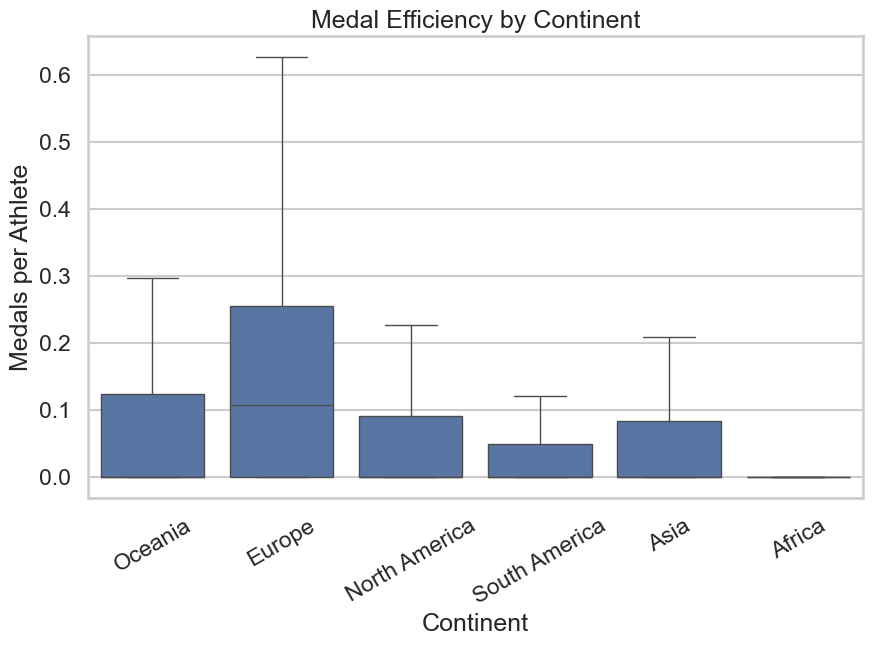

In [185]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=country_year,
    x="continent",
    y="medals_per_athlete",
    showfliers=False
)
plt.title("Medal Efficiency by Continent")
plt.xlabel("Continent")
plt.ylabel("Medals per Athlete")
plt.xticks(rotation=30)
plt.show()

#### Delagation Size vs Medal Count

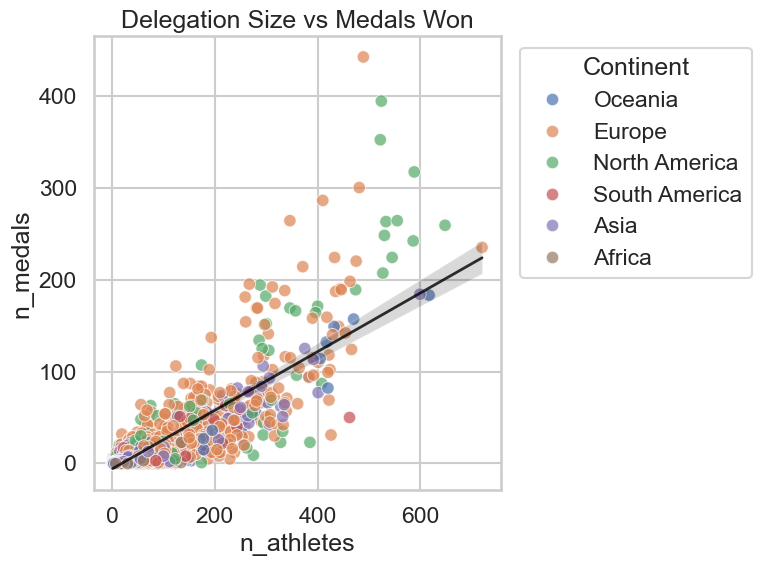

In [186]:
# Delagation size vs medals won
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=country_year,
    x="n_athletes",
    y="n_medals",
    hue="continent",
    alpha=0.7
)
plt.title("Delegation Size vs Medals Won")
plt.xlabel("Number of Athletes")
plt.ylabel("Number of Medals")

sns.regplot(
    data=country_year,
    x="n_athletes",
    y="n_medals",
    scatter=False,
    color="black",
    line_kws={"linewidth": 2, "alpha": 0.8}
)
plt.legend(title="Continent", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

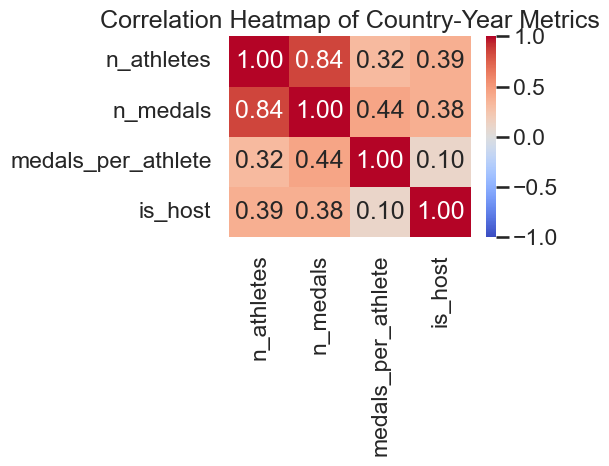

In [195]:
country_year.columns

num_cols = [
    "n_athletes",
    "n_medals",
    "medals_per_athlete",
    "is_host",
]

corr = country_year[num_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1
)
plt.title("Correlation Heatmap of Country-Year Metrics")
plt.tight_layout()
plt.show()

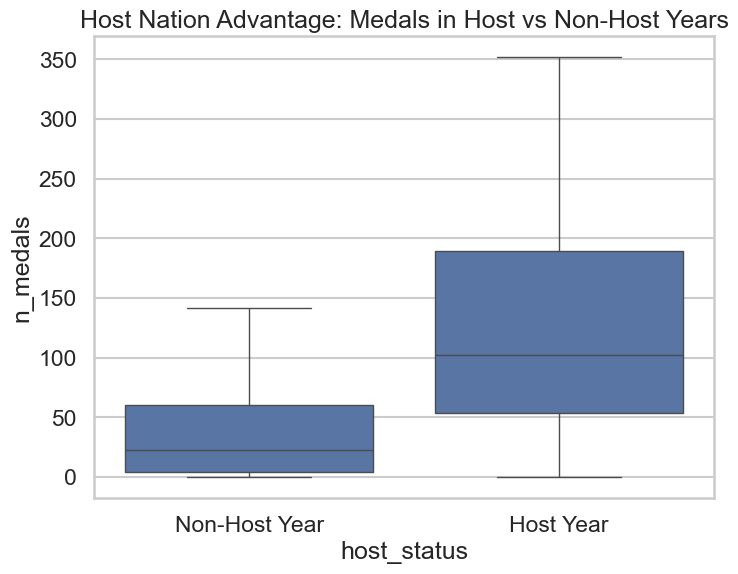

In [188]:
host_countries = country_year[country_year["is_host"] == 1]["country_name"].unique()
host_panel = country_year[country_year["country_name"].isin(host_countries)].copy()
host_panel["host_status"] = np.where(host_panel["is_host"] == 1, "Host Year", "Non-Host Year")

plt.figure(figsize=(8,6))
sns.boxplot(data=host_panel, x="host_status", y="n_medals", showfliers=False)
plt.title("Host Nation Advantage: Medals in Host vs Non-Host Years")
plt.show()

In [ ]:
# choropleth map of total medals
total_medals_country = (
    country_year
    .groupby("country_name", as_index=False)["n_medals"]
    .sum()
)

# avoid weird values by adding a log-transformed version
total_medals_country["log_medals"] = np.log1p(total_medals_country["n_medals"])

fig = px.choropleth(
    total_medals_country,
    locations="country_name",
    locationmode="country names",
    color="log_medals",          
    hover_name="country_name",
    hover_data={"n_medals": True, "log_medals": False},
    color_continuous_scale="Viridis",
    title="Total Summer Olympic Medals by Country (1912+)",
)

fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0),
    coloraxis_colorbar=dict(
        title="log(1 + medals)"
    )
)

fig.show()

C:\Users\Owen Schillaci\AppData\Local\Temp\ipykernel_11444\4016007453.py:11: DeprecationWarning: The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.
  fig = px.choropleth(


## Models

In [ ]:
# create a regression model for predicinting how participation will change over time
# create model for predicting medal counts
# fit model for prediciting medals per athlete
# t-test for host nation advantage
# predict whether a nation will win any medal
# add geneder data to eda
